## Mounting my Drive so I can access the images. Here is where you should change the PATH variable such that it points to every images used in this notebook.

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

PATH = 'drive/MyDrive/Colab_Notebooks/'

#To check if I am accessing the right directory
!ls $PATH

Mounted at /content/drive
ECSE_415_A5.ipynb  landscape.png  Montreal_Picture.jpg	Person.png  street.png


### Disclaimer, part of this notebook was adapted from Tutorial 9 and taken from https://cv.gluon.ai/build/examples_detection/demo_faster_rcnn.html which offers a tutorial on how to use the MRCNN pre-trained model on my images





## Imports Necessary for this notebook to work with their respective versions

In [11]:
!pip install numpy==1.23.5
!pip install matplotlib==3.7.1
!pip install opencv-python==4.8.0.76
!pip install scikit-learn==1.2.2
!pip install torch==1.11.0+cpu torchvision==0.12.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install --upgrade gluoncv
!pip install mxnet

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu118
    Uninstalling torchvision-0.16.0+cu118:
      Successfully uninstalled torchvision-0.16.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 1.11.0+cpu which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.11.0+cpu which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but

## Required Imports for part 1

In [12]:
#Required Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

## Image Class that pre-processes an image given a path to this image. This Class also contains functions to apply haar filters, and segment an image using k-mean and mean-shift clustering.


In [13]:

class Image:

    def __init__(self, image_path, name = None):
        # Load the image from the specified path
        # OpenCV loads images in BGR format by default
        self.image = cv2.imread(image_path)

        self.image_rgb = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)

        self.image_path = image_path

        if name is not None:
            self.set_name(name = name)
        if self.image is None:
            raise ValueError(f"Image not found at {image_path}")


    def set_name(self, name):
        self.name = name

    def display(self):
        # Convert the image from BGR to RGB format for displaying
        rgb_image = self.image_rgb
        # Display the image using matplotlib
        plt.imshow(rgb_image)
        plt.axis('off')  # Turn off axis numbers
        plt.title(self.name)
        plt.show()

    #Function to apply haar filter to image. Can be used with horizontal/checkerboard filter
    def apply_haar_filter(self, filter_type):

        template_zeros = np.zeros_like(self.image, dtype= np.float64)

        #Title of displayed image based on arguments
        if filter_type == 'horizontal_edge':
            kernel = np.ones((12,24), dtype = np.float64)
            kernel[6:,:] = -1

            for i in range(3):
                template_zeros[:,:,i] = cv2.filter2D(src = self.image_rgb[:,:,i], ddepth = -1, kernel = kernel, borderType = cv2.BORDER_CONSTANT)

            template_zeros = (template_zeros - np.min(template_zeros) ) / (np.max(template_zeros) - np.min(template_zeros))
            plt.title(self.name + ' horizontal_edge haar filter')
            #Set feature_image as attribute of class
            self.feature_image_horizontal = template_zeros

        elif filter_type == 'checkerboard':
            kernel = np.ones((24,24), dtype = np.float64)
            kernel[:12,:12:] = -1
            kernel[12:, 12:] = -1

            for i in range(3):
                template_zeros[:,:,i] = cv2.filter2D(src = self.image_rgb[:,:,i], ddepth = -1, kernel = kernel, borderType = cv2.BORDER_CONSTANT)

            template_zeros = (template_zeros - np.min(template_zeros) ) / (np.max(template_zeros) - np.min(template_zeros))
            plt.title(self.name + ' checkerboard haar filter')
            self.feature_image_checkerboard = template_zeros

        # Display the feature image using matplotlib
        plt.imshow(template_zeros, cmap='gray')
        plt.axis('off')
        plt.show()



    # K-Mean clustering for segmentation using the feature image from the haar_filter
    def segment(self, K=3):

        X = np.concatenate([self.feature_image_horizontal.reshape(-1,3), self.feature_image_checkerboard.reshape(-1,3)], axis = 1)

        # Apply K-means clustering to these feature vectors
        labels = KMeans(n_clusters=K, n_init = 10, random_state=0).fit_predict(X)

        # Reshape the result back into the original image shape
        segmented_image = labels.reshape(self.image_rgb.shape[:2])

        # Display the segmented image using matplotlib
        plt.imshow(segmented_image)
        plt.axis('off')  # Turn off axis numbers
        plt.title(f'{self.name} Segmented Image with K=' + str(K))
        plt.show()

        return segmented_image


    # Mean-Shift Clustering for segmentation using Haar features
    def segment_meanshift(self):
        # Ensure that the Haar features have been computed

        X = np.reshape(self.image_rgb, (-1,3))

        #Using the parameters for bandwidth from the tutorial, else this function crashes (runs out of memory)
        bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples = 500)

        # Initialize MeanShift with the given bandwidth
        meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)

        # Fit the data (this may take some time depending on the size of the feature space)
        meanshift.fit(X)

        # Predict the segmentation
        labels = meanshift.labels_

        cluster_centers = meanshift.cluster_centers_

        # Reshape the result back into the original image shape using cluster centers at labels
        segmented_image = cluster_centers[labels].reshape(self.image_rgb.shape)

        # Display the segmented image using matplotlib
        plt.imshow(segmented_image.astype(np.uint8))
        plt.axis('off')  # Turn off axis numbers
        plt.title(f'{self.name} MeanShift Segmentation')
        plt.show()


## Initialize Image Objects For all of the assignment. My Montreal Picture image is called Montreal_Picture.jpg. You may change that name to any image that you will run part 2 of this assignment on to.

In [14]:
#Initialize Image Objects for the four pictures (Person, Landscape, Street, Montreal_Picture)
Person = Image(image_path = PATH + 'Person.png', name = 'Person')

Landscape = Image(image_path = PATH + 'landscape.png', name = 'Landscape')
Street = Image(image_path = PATH + 'street.png', name = 'Street')
Montreal_Picture = Image(image_path = PATH + 'Montreal_Picture.jpg', name = 'Montreal Street')

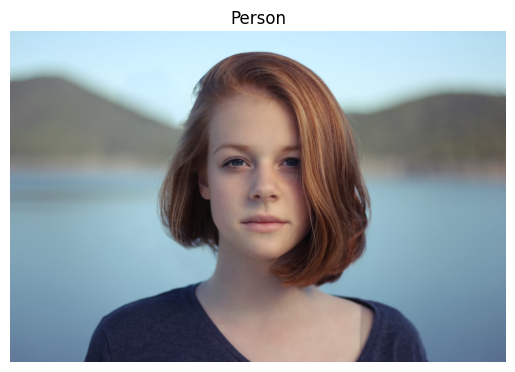

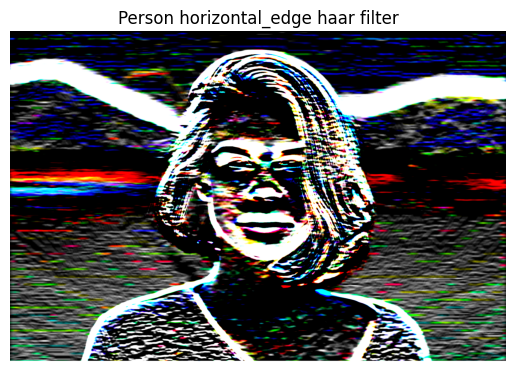

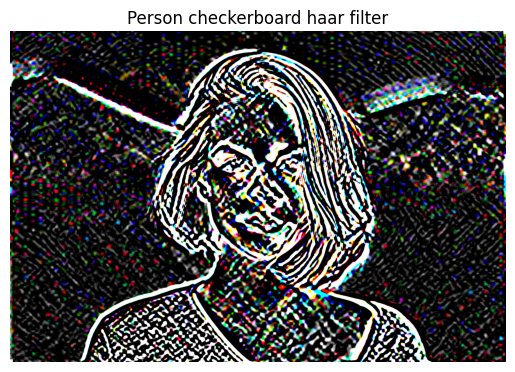

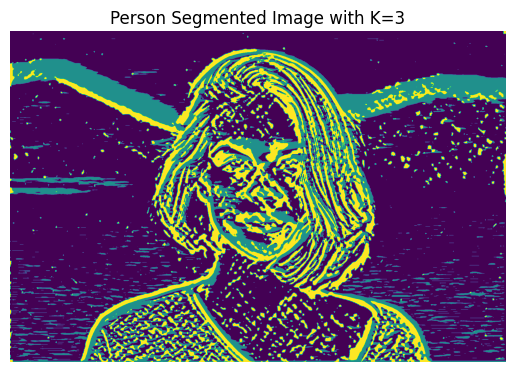

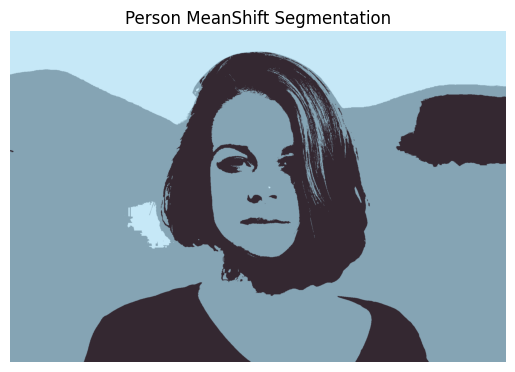

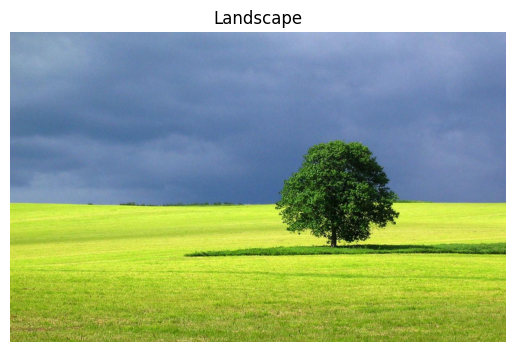

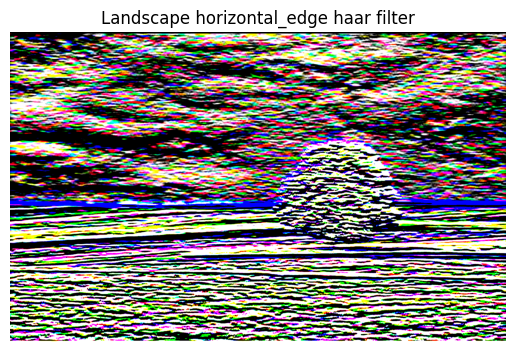

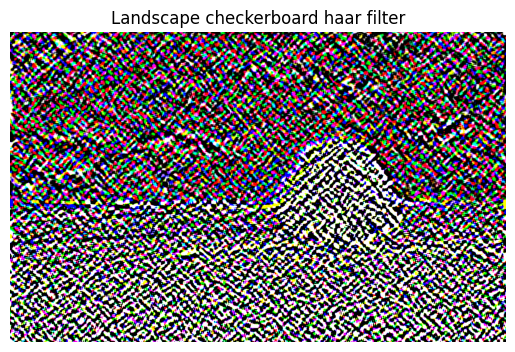

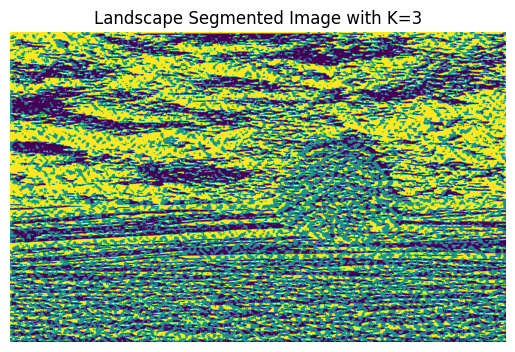

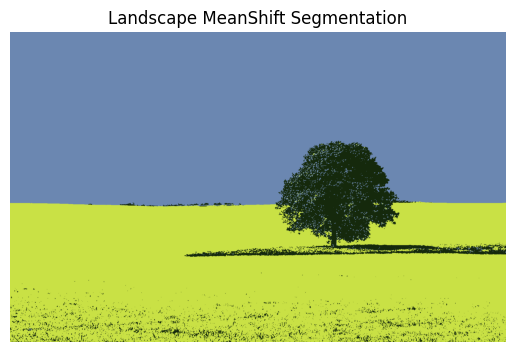

In [15]:
# For the Person and Landscape Image, Apply Haar Filter (Checkerboard and horizontal_edge)
# And display the results. Note that the Apply Haar Filter function grayscales the images first and
# Normalizes the results

# For these same images, segment them using k-mean clustering and the feature_images from the haar_filters
# Apply filters and segment images for each filter type
for image in [Person, Landscape]:

    #Displaying Original Image
    image.display()

    for filter_type in ['horizontal_edge', 'checkerboard']:
        # Apply Haar filter and get feature image
        image.apply_haar_filter(filter_type)



    # Segment the image using the haar filter features using k-mean clustering and display the segmented images
    image.segment(K=3)

    # Segment the image based on the mean-shift clustering and display the segmented images
    image.segment_meanshift()


# K-Means Clustering

#### Benefits:

###### Efficiency: K-means is known for its computational speed, which makes it suitable for large datasets.

######Simplicity: The algorithm is straightforward to implement and easy to understand.
######Scalability: It can handle large-scale image segmentation tasks with relative ease.

####Limitations:

######Predefined Clusters: It requires the number of clusters to be set in advance, which might not be known.

######Sensitivity to Initialization: The results can vary significantly based on the initial placement of centroids.

######Cluster Assumptions: Assumes clusters are spherical and evenly sized, which isn’t always the case in images.

#Mean-Shift Clustering

####Benefits:

###### No Assumption of Cluster Shape: It can detect clusters of any shape, providing flexibility in segmenting images.
###### No Need to Specify Cluster Number: The algorithm automatically determines the number of clusters.
###### Robustness to Outliers: More resilient to noise and outliers compared to K-means.

####Limitations:

######Computationally Demanding: Mean-shift is resource-intensive, especially for high-resolution images.

######Bandwidth Sensitivity: The choice of bandwidth parameter is crucial and can significantly influence the results.

######Scaling Issues: It does not scale well with the size of the data, limiting its use in larger datasets.

##Imports Necessary for Part 2

In [16]:
from gluoncv import model_zoo, data, utils
net = model_zoo.get_model('mask_rcnn_resnet50_v1b_coco', pretrained = True)
import time

/usr/local/lib/python3.10/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.11.0+cpu` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


100%|██████████| 131497/131497 [00:04<00:00, 27371.42KB/s]


##MRCNN Class that has a run function that takes an image object as input. This class runs the Mask R-CNN model on the image, and displays the output image with its bounded boxes and labels. It also returns some metrics for that image's computation such as the time elapsed to run the model on the image and the confidence levels of said labels

In [45]:
#Mask RCNN Class
class MRCNN:

    def __init__(self):
        pass


    #This function implements the pre-trained Mask R-CNN model, display the input
    #image with their bounding boxes/labels and returns some specs to analyze the quality of the model
    def run(self, Image):

        #Start time of run function
        start_time = time.time()

        im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                                  'gluoncv/detection/biking.jpg?raw=true',
                                  path = Image.image_path)

        x, orig_img = data.transforms.presets.rcnn.load_test(im_fname)

        scores_list = []
        times_list = []

        ids, scores, bboxes, masks = [xx[0].asnumpy() for xx in net(x)]

        end_time = time.time()

        elapsed_time = end_time - start_time

        scores_list.append(scores)
        times_list.append(elapsed_time)

        width, height = orig_img.shape[1], orig_img.shape[0]
        masks, _ = utils.viz.expand_mask(masks, bboxes, (width, height), scores)
        orig_img = utils.viz.plot_mask(orig_img, masks)

        #plotting image with bounding boxes

        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(1,1,1)
        ax = utils.viz.plot_bbox(orig_img, bboxes, scores, ids,
                                 class_names = net.classes, ax = ax)
        plt.show()

        return scores_list,times_list


    def confidence_analysis(self, scores, Image):

      for i,score in enumerate(scores):
        formatted_score = scores[i].flatten()
        formatted_score = formatted_score[formatted_score >= 0]

        different_scores, frequency = np.unique(formatted_score, return_counts = True)
        number_bins = len(different_scores)

        #Histogram of accuracy as a function of frequency for the model
        plt.hist(formatted_score, bins = number_bins)
        plt.xlabel('Confidence')
        plt.ylabel('Frequency')
        plt.title(f'Confidence of object recognized and the frequency of said recognized objects for {Image.name}')

    def time_analysis(self, time_1, time_2, Image_1, Image_2):
      plt.bar(np.array([Image_1.name,Image_2.name]), [time_1[0], time_2[0]], color = ['blue','red'], width = 0.03)
      plt.xlabel(f'{Image_1.name} and {Image_2.name}')
      plt.ylabel('Time Elapsed (seconds)')
      plt.title('Time to Completion of MRCNN model for Object Detection')
      plt.show()




## Instantiate a MRCNN object and run it on the Street Image and my Montreal Picture Image

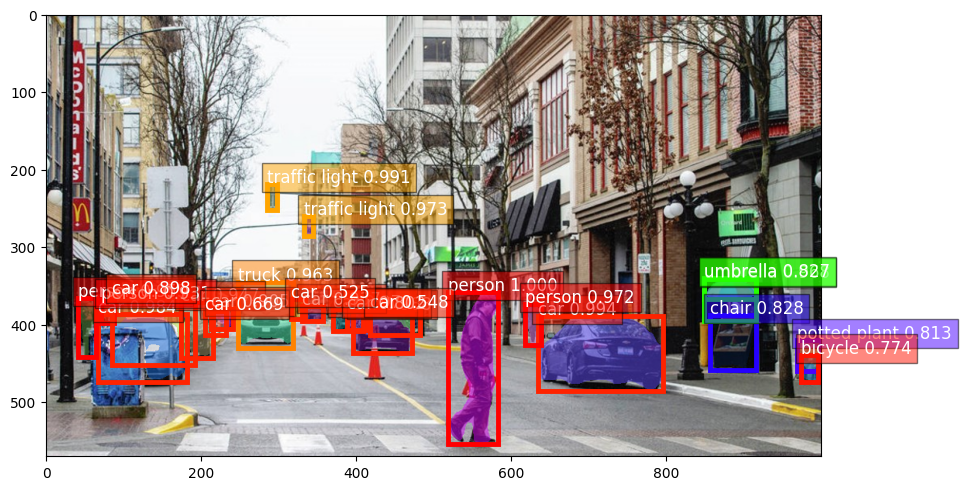

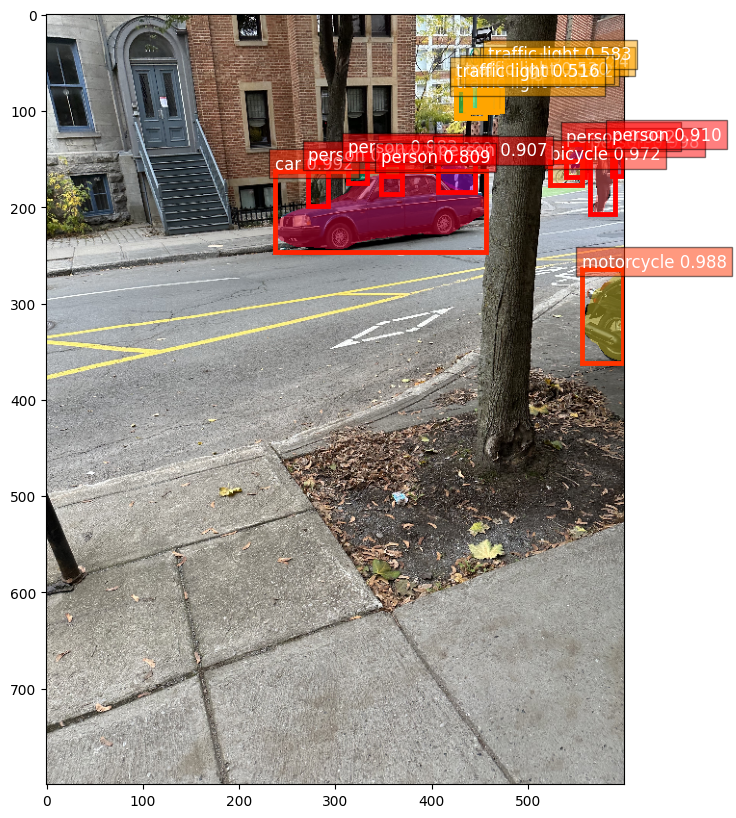

In [46]:
Model = MRCNN()
street_scores, street_times = Model.run(Image = Street)
Mtl_scores, Mtl_times = Model.run(Image = Montreal_Picture)


#### Confidence analysis of the street.png image

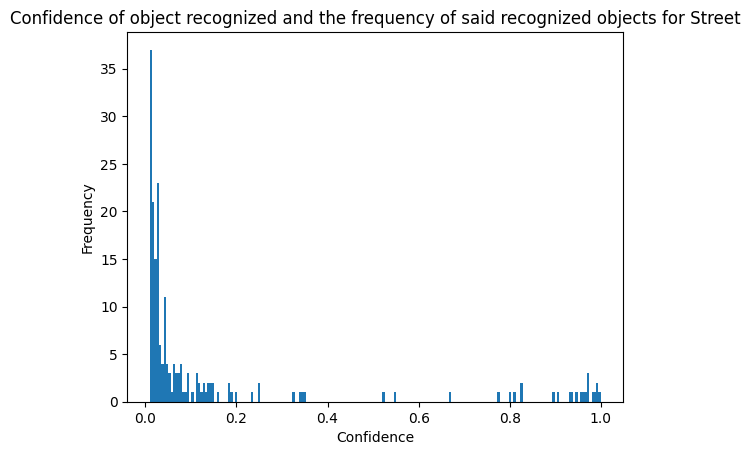

In [47]:
Model.confidence_analysis(scores = street_scores, Image = Street)

#### Confidence analysis of my Montreal_Picture.jpg image.

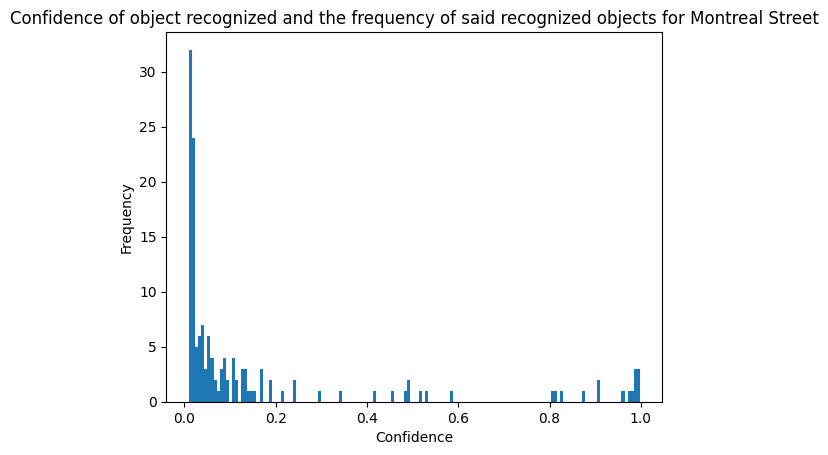

In [48]:
Model.confidence_analysis(scores = Mtl_scores, Image = Montreal_Picture)

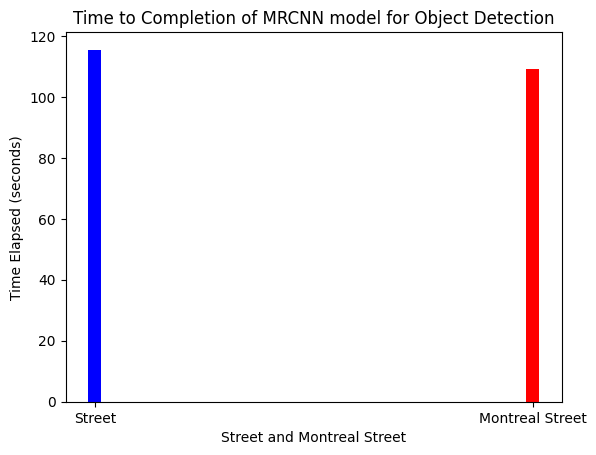

In [50]:
Model.time_analysis(time_1 = street_times, time_2 = Mtl_times, Image_1 = Street, Image_2 = Montreal_Picture)

Analyzing the performance of the MRCNN model with pre-trained weight is not something that can be trivially done using the plots that have been shown in this notebook. These results of the model's performance are really limited to two images which makes it pretty impossible to generalize the model's performance for object detection on images. A larger set of images to test the model against would yield more relevant information of its performance.

As of how the model manages to perform object detection, Mask R-CNN combines object detection and instance segmentation. The steps that this network takes (information available from the library's documentation) are the following. The model processes an image as the input to their pre-trained convolutional neural network for feature extraction. It makes use of a FPN (Feature Pyramid Network) to construct a multi-scale feature pyramid that captures contextual information across different scales of the image. This enables better object detectoin and segmentation for a wide range of object sizes. Then, the model makes use of a RPN (Region Proposal Network) that generates potential object regions based on the extracted features (these are referred to as proposals). These proposals are subjected to transformations such as cropping/resizing using ROIAlign to address dimension issues with the traditional ROI pooling. This offers more accurate segmentation masks (especially for small objects). Those segmentation masks are generated by what they call the Mask Head layer. This component of the model uses the aligned features outputted from the ROIAlign layer to predict  abinary mask for each objects. Finally, with these regions processed, the model predicts a label for each of them through object class probabilities and refines bounding box coordinates.